<a href="https://colab.research.google.com/github/MadhavMalik/Investing-Model-Using-Moving-Average/blob/main/New_Investing_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import yfinance as yf

def get_stock_data(symbol, period):
    """
    Function to fetch stock data using yfinance.

    Parameters:
        symbol (str): Stock symbol (e.g., "AAPL" for Apple Inc.).
        period (str): Period for which data should be fetched (e.g., "1y" for 1 year).

    Returns:
        pandas.DataFrame: DataFrame containing stock data.
    """
    stock_data = yf.download(symbol, period=period)
    return stock_data

def calculate_sma(data, window):
    """
    Function to calculate the n-day Simple Moving Average (SMA).

    Parameters:
        data (pandas.DataFrame): DataFrame containing stock data.
        window (int): Number of periods to calculate the SMA.

    Returns:
        pandas.Series: Series containing the SMA values.
    """
    sma = data['Close'].rolling(window=window).mean()
    return sma

# Example usage:
symbol = "ITC.NS"  # Example stock symbol (Apple Inc.)
period = "3y"  # Period for which data should be fetched
window = 200  # Number of days for SMA calculation

# Fetch stock data
stock_data = get_stock_data(symbol, period)

# Calculate SMA
sma = calculate_sma(stock_data, window)

print(sma)


[*********************100%%**********************]  1 of 1 completed

Date
2021-05-07          NaN
2021-05-10          NaN
2021-05-11          NaN
2021-05-12          NaN
2021-05-14          NaN
                ...    
2024-04-26    443.00100
2024-04-29    442.86025
2024-04-30    442.66300
2024-05-02    442.48850
2024-05-03    442.32875
Name: Close, Length: 739, dtype: float64


In [40]:


def detect_crossovers(data, sma):
    """
    Function to detect crossovers between stock price and SMA.

    Parameters:
        data (pandas.DataFrame): DataFrame containing stock data.
        sma (pandas.Series): Series containing the SMA values.

    Returns:
        dict: Dictionary containing crossover dates and types (from above or from below).
    """
    crossovers = {'from_below': [], 'from_above': []}
    for i in range(1, len(data)):
        if data['Close'][i] > sma[i] and data['Close'][i - 1] <= sma[i - 1]:
            crossovers['from_below'].append(data.index[i])
        elif data['Close'][i] < sma[i] and data['Close'][i - 1] >= sma[i - 1]:
            crossovers['from_above'].append(data.index[i])
    return crossovers


# Detect crossovers
crossovers = detect_crossovers(stock_data, sma)

print("Crossovers from below:", crossovers['from_below'])
print("Crossovers from above:", crossovers['from_above'])


Crossovers from below: [Timestamp('2022-03-04 00:00:00')]
Crossovers from above: [Timestamp('2024-01-30 00:00:00')]


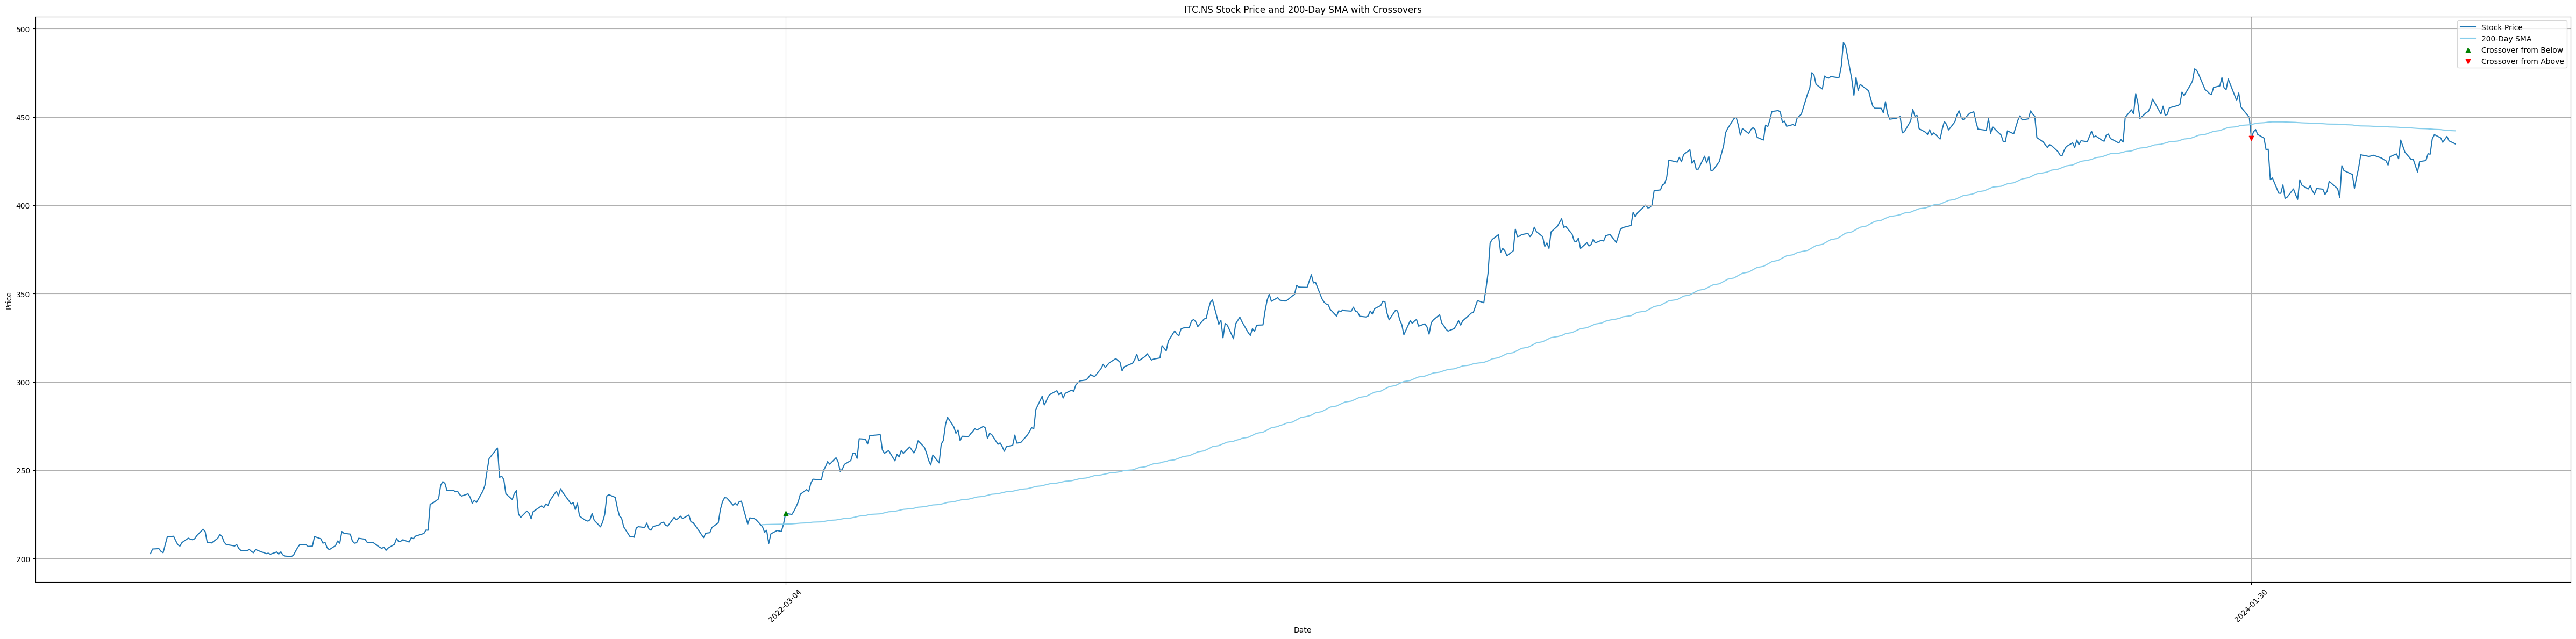

In [41]:
import matplotlib.pyplot as plt

# Plot stock prices and SMA with crossover dates
plt.figure(figsize=(48,12))

# Plot stock price and SMA lines
plt.plot(stock_data.index, stock_data['Close'], label='Stock Price', zorder=1)
plt.plot(sma.index, sma, label=f'{window}-Day SMA', color='skyblue', zorder=2)

# Plot scatter markers for crossovers
plt.scatter(crossovers['from_below'], stock_data.loc[crossovers['from_below']]['Close'], color='green', marker='^', label='Crossover from Below', zorder=3)
plt.scatter(crossovers['from_above'], stock_data.loc[crossovers['from_above']]['Close'], color='red', marker='v', label='Crossover from Above', zorder=3)

# Customize plot appearance
plt.title(f'{symbol} Stock Price and {window}-Day SMA with Crossovers')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(crossovers['from_below'] + crossovers['from_above'], rotation=45)  # Set x-axis ticks to crossover dates
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
def note_crossovers(stock_data, sma):
    """
    Function to note the exact moving price when the stock price crossed the next day.

    Parameters:
        stock_data (pandas.DataFrame): DataFrame containing stock data.
        sma (pandas.Series): Series containing the SMA values.

    Returns:
        dict: Dictionary containing crossover dates, prices, and types (from above or from below).
    """
    crossovers = {'from_below': [], 'from_above': []}
    for i in range(1, len(stock_data)):
        if stock_data['Close'][i] > sma[i] and stock_data['Close'][i - 1] <= sma[i - 1]:
            crossovers['from_below'].append({'date': stock_data.index[i], 'price': stock_data['Close'][i], 'sma': sma[i]})
        elif stock_data['Close'][i] < sma[i] and stock_data['Close'][i - 1] >= sma[i - 1]:
            crossovers['from_above'].append({'date': stock_data.index[i], 'price': stock_data['Close'][i], 'sma': sma[i]})
    return crossovers

# Note crossovers
crossovers_info = note_crossovers(stock_data, sma)

# Print crossovers from below and above with exact price and SMA
print("Crossovers from below:")
for crossover in crossovers_info['from_below']:
    print(f"Date: {crossover['date']}, Price: {crossover['price']}, SMA: {crossover['sma']}")
print("\nCrossovers from above:")
for crossover in crossovers_info['from_above']:
    print(f"Date: {crossover['date']}, Price: {crossover['price']}, SMA: {crossover['sma']}")

print(crossovers_info)

Crossovers from below:
Date: 2022-03-04 00:00:00, Price: 225.5, SMA: 219.4944997406006

Crossovers from above:
Date: 2024-01-30 00:00:00, Price: 438.04998779296875, SMA: 445.81500061035155
{'from_below': [{'date': Timestamp('2022-03-04 00:00:00'), 'price': 225.5, 'sma': 219.4944997406006}], 'from_above': [{'date': Timestamp('2024-01-30 00:00:00'), 'price': 438.04998779296875, 'sma': 445.81500061035155}]}


In [43]:
def combine_crossovers(crossovers_info):
    """
    Function to combine crossovers from below and crossovers from above.

    Parameters:
        crossovers_info (dict): Dictionary containing crossover dates, prices, and types (from above or from below).

    Returns:
        list: List of combined crossovers with type attribute, sorted by date.
    """
    combined_crossovers = []

    for crossover in crossovers_info['from_below']:
        crossover['type'] = 'from_below'
        combined_crossovers.append(crossover)

    for crossover in crossovers_info['from_above']:
        crossover['type'] = 'from_above'
        combined_crossovers.append(crossover)

    # Sort combined crossovers by date
    combined_crossovers.sort(key=lambda x: x['date'])

    return combined_crossovers

# Combine crossovers
combined_crossovers = combine_crossovers(crossovers_info)

# Print combined crossovers with type attribute, sorted by date
print("Combined crossovers:")
for crossover in combined_crossovers:
    print(f"Date: {crossover['date']}, Price: {crossover['price']}, SMA: {crossover['sma']}, Type: {crossover['type']}")


Combined crossovers:
Date: 2022-03-04 00:00:00, Price: 225.5, SMA: 219.4944997406006, Type: from_below
Date: 2024-01-30 00:00:00, Price: 438.04998779296875, SMA: 445.81500061035155, Type: from_above


In [44]:
def calculate_returns(combined_crossovers, stock_data):
    """
    Function to calculate returns/profits from crossovers.

    Parameters:
        combined_crossovers (list): List of combined crossovers with type attribute, sorted by date.
        stock_data (pandas.DataFrame): DataFrame containing stock data.

    Returns:
        float: Total profits from crossovers in percentage.
    """
    bought = False
    buy_price = 0
    total_return = 0

    for crossover in combined_crossovers:
        if crossover['type'] == 'from_below':
            if not bought:
                buy_price = crossover['sma']  # Buy at SMA price
                bought = True
                print(f"Bought at {buy_price} on {crossover['date']}")
            else:
                print(f"Already bought at {buy_price}, no crossover from below to buy again")
        elif crossover['type'] == 'from_above':
            if bought:
                sell_price = crossover['sma']  # Sell at SMA price
                percentage_return = ((sell_price - buy_price) / buy_price) * 100
                total_return += percentage_return
                print(f"Sold at {sell_price} on {crossover['date']}, Percentage Return: {percentage_return}%")
                bought = False
            else:
                print("No stock bought to sell")

    if bought:
        # If there are no more crossovers from above but the stock is still bought,
        # we sell the stock at the last available price
        last_price = stock_data.iloc[-1]['Close']
        percentage_return = ((last_price - buy_price) / buy_price) * 100
        total_return += percentage_return
        print(f"Sold at {last_price} on {stock_data.index[-1]}, Percentage Return: {percentage_return}%")

    return total_return

# Calculate returns
percentage_profit = calculate_returns(combined_crossovers, stock_data)
print("Total profits from crossovers:", percentage_profit, "%")


Bought at 219.4944997406006 on 2022-03-04 00:00:00
Sold at 445.81500061035155 on 2024-01-30 00:00:00, Percentage Return: 103.10987343064058%
Total profits from crossovers: 103.10987343064058 %


In [85]:
# Stocks to watch
# If their current closing price is +- 10% of the current moving average

import pandas as pd
ticks = pd.read_csv("/content/valid_ticks.csv")


In [90]:
watch_ticks = []
count = 1
watch_count = 1

for tick in ticks['ticks']:
     # Example usage:
    symbol = tick + ".NS"
    period = "3y"
    window = 200
    stock_data = get_stock_data(symbol, period)
    sma = calculate_sma(stock_data, window)
    if (stock_data['Close'][-1] >= sma[-1]*0.93 and stock_data['Close'][-1] <= sma[-1]*1.07):
        watch_ticks.append(tick)
        print("Tick:", tick, ":: Watch count:", watch_count)
        watch_count += 1
    print(count)
    count += 1

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1
Tick: TCS :: Watch count: 1
2
Tick: HDFCBANK :: Watch count: 2
3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


4
5
6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: INFY :: Watch count: 3
7
8
Tick: ITC :: Watch count: 4
9


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


10
11
Tick: BAJFINANCE :: Watch count: 5
12


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: HCLTECH :: Watch count: 6
13
14
15


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ADANIENT :: Watch count: 7
16
17
Tick: TITAN :: Watch count: 8
18


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


19
20


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


21
22
23
24


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


25
26
Tick: ASIANPAINT :: Watch count: 9
27


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


28
Tick: BAJAJFINSV :: Watch count: 10
29
30


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


31
Tick: NESTLEIND :: Watch count: 11
32
Tick: WIPRO :: Watch count: 12
33


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


34
35
36


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


37
38
39


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


40
41


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


42
43
44


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


45
46
47


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SBILIFE :: Watch count: 13
48
49
50


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


51
52
53


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


54
55


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


56
57


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


58
59


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


60
61
62


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: TECHM :: Watch count: 14
63
64
Tick: INDUSINDBK :: Watch count: 15
65


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


66
67
68


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: BRITANNIA :: Watch count: 16
69
70
71


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


72
73
74


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


75
76
77


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


78
79


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


80
81
82


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


83
84
Tick: DABUR :: Watch count: 17
85


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SHREECEM :: Watch count: 18
86
87
Tick: BAJAJHLDNG :: Watch count: 19
88


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


89
90


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


91
92


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


93
94


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ICICIPRULI :: Watch count: 20
95
96
97


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


98
99
100


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


101
102
103


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


104
105
106


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


107
108
109


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


110
111
112


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


113
114
115


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


116
117
118


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


119
120
121


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


122
123
Tick: SBICARD :: Watch count: 21
124


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: MARICO :: Watch count: 22
125
126
127


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


128
129


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: PERSISTENT :: Watch count: 23
130
131
132


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


133
Tick: PIIND :: Watch count: 24
134
135


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


136
Tick: TATACOMM :: Watch count: 25
137
138


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: MRF :: Watch count: 26
139
140


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: PGHH :: Watch count: 27
141
142
143


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


144
145
146


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


147
Tick: IDFCFIRSTB :: Watch count: 28
148
149


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


150
151
152
153


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


154
155
156


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


157
158
Tick: PATANJALI :: Watch count: 29
159


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


160
161
162


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


163
164
165


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


166
Tick: MPHASIS :: Watch count: 30
167
Tick: BALKRISIND :: Watch count: 31
168


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


169
170
171


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


172
Tick: AWL :: Watch count: 32
173
Tick: APLAPOLLO :: Watch count: 33
174
175


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SONACOMS :: Watch count: 34
176
177
Tick: FACT :: Watch count: 35
178


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


179
180
181


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


182
183
184


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


185
186
187


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


188
Tick: CRISIL :: Watch count: 36
189
Tick: AIAENG :: Watch count: 37
190


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


191
192
193


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


194
195
196


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


197
Tick: 3MINDIA :: Watch count: 38
198
Tick: MFSL :: Watch count: 39
199


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


200
201
202


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


203
204
205


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


206
207
Tick: DELHIVERY :: Watch count: 40
208


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


209
Tick: STARHEALTH :: Watch count: 41
210
211


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


212
213


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


214
215


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


216
217


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


218
219


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


220
221
Tick: GLAND :: Watch count: 42
222


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: IGL :: Watch count: 43
223
224
225


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: JUBLFOOD :: Watch count: 44
226
227
228


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


229
230


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


231
232


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


233
234
235


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


236
237


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: TATACHEM :: Watch count: 45
238
239
240


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


241
242
243


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


244
245


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


246
247
Tick: ANGELONE :: Watch count: 46
248


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


249
250
251


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


252
253
Tick: SUNTV :: Watch count: 47
254


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


255
256
257


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SUNDRMFAST :: Watch count: 48
258
Tick: CREDITACC :: Watch count: 49
259
260


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: HATSUN :: Watch count: 50
261
262
Tick: CYIENT :: Watch count: 51
263


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


264
265
266


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


267
268
Tick: GILLETTE :: Watch count: 52
269


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


270
271
Tick: GRINDWELL :: Watch count: 53
272


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: FIVESTAR :: Watch count: 54
273
274
Tick: CHOLAHLDNG :: Watch count: 55
275


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


276
Tick: SKFINDIA :: Watch count: 56
277
Tick: BSOFT :: Watch count: 57
278


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


279
Tick: RELAXO :: Watch count: 58
280
Tick: SONATSOFTW :: Watch count: 59
281


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: GSPL :: Watch count: 60
282
Tick: RATNAMANI :: Watch count: 61
283
284


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


285
Tick: PFIZER :: Watch count: 62
286


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


287
288
Tick: PEL :: Watch count: 63
289


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


290
Tick: LALPATHLAB :: Watch count: 64
291
Tick: EMAMILTD :: Watch count: 65
292


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


293
294
Tick: TRIDENT :: Watch count: 66
295


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


296
297
Tick: KAYNES :: Watch count: 67
298


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


299
300
301
302


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


303
304
Tick: IDFC :: Watch count: 68
305


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


306
Tick: CIEINDIA :: Watch count: 69
307
308
309


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SUMICHEM :: Watch count: 70
310
311
312


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


313
314
315


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


316
317
Tick: ATUL :: Watch count: 71
318


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


319
320
321


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


322
Tick: KIMS :: Watch count: 72
323
324
Tick: PNBHOUSING :: Watch count: 73
325


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


326
327
Tick: JYOTHYLAB :: Watch count: 74
328


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


329
330
331


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


332
333
Tick: INDIAMART :: Watch count: 75
334


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


335
336
Tick: WHIRLPOOL :: Watch count: 76
337


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


338
339
340


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: APTUS :: Watch count: 77
341
Tick: FINCABLES :: Watch count: 78
342
343


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


344
Tick: VINATIORGA :: Watch count: 79
345
346


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


347
348


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


349
350
351


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: AFFLE :: Watch count: 80
352
353
Tick: RBLBANK :: Watch count: 81
354


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


355
356
357


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


358
359
Tick: CENTURYPLY :: Watch count: 82
360


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: CLEAN :: Watch count: 83
361
362
363


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


364
365
366


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


367
368


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

369
370



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


371
372
373


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: DCMSHRIRAM :: Watch count: 84
374
375


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


376
377
378


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


379
380
381
382


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


383
384
385


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


386
387
388


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


389
390
Tick: WESTLIFE :: Watch count: 85
391


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: RKFORGE :: Watch count: 86
392
393
394


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: FINEORG :: Watch count: 87
395
396
Tick: BIKAJI :: Watch count: 88
397
398


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


399
400
401


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


402
403
404


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


405
Tick: ECLERX :: Watch count: 89
406
407


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ERIS :: Watch count: 90
408
409
410


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


411
412
413


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


414
415
416


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


417
418
419


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


420
421
Tick: NUVOCO :: Watch count: 91
422


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: AKZOINDIA :: Watch count: 92
423
Tick: CEATLTD :: Watch count: 93
424
425


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


426
427


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

428
429



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


430
431
Tick: EQUITASBNK :: Watch count: 94
432
433


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


434
Tick: LATENTVIEW :: Watch count: 95
435
436


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: AAVAS :: Watch count: 96
437
438
439
440


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: JKLAKSHMI :: Watch count: 97
441
442
443


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


444
Tick: MAPMYINDIA :: Watch count: 98
445
Tick: ROUTE :: Watch count: 99
446


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: CANFINHOME :: Watch count: 100
447
448
Tick: SAPPHIRE :: Watch count: 101
449


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


450
451


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


452
453
454


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: PRAJIND :: Watch count: 102
455
456


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


457
458


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


459
460
461
462


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


463
464
465


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ZYDUSWELL :: Watch count: 103
466
467
468


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: TTKPRESTIG :: Watch count: 104
469
470
Tick: GNFC :: Watch count: 105
471


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


472
Tick: CRAFTSMAN :: Watch count: 106
473
474


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


475
476
477


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: NETWORK18 :: Watch count: 107
478
Tick: PRSMJOHNSN :: Watch count: 108
479
480


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


481
482
483


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


484
Tick: UJJIVANSFB :: Watch count: 109
485
486


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


487
Tick: RATEGAIN :: Watch count: 110
488
489


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SAFARI :: Watch count: 111
490
491
492


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SHOPERSTOP :: Watch count: 112
493
Tick: IBULHSGFIN :: Watch count: 113
494
495


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


496
Tick: ACI :: Watch count: 114
497
498


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: MAHSCOOTER :: Watch count: 115
499
500
501


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ESABINDIA :: Watch count: 116
502
Tick: GALAXYSURF :: Watch count: 117
503
504


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


505
506
Tick: HOMEFIRST :: Watch count: 118
507


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: MHRIL :: Watch count: 119
508
509
Tick: KTKBANK :: Watch count: 120
510


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


511
Tick: MASTEK :: Watch count: 121
512


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


513
514


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: CCL :: Watch count: 122
515
516


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


517
518
Tick: VARROC :: Watch count: 123
519


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: TMB :: Watch count: 124
520
521
522


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


523
Tick: IONEXCHANG :: Watch count: 125
524
Tick: RESPONIND :: Watch count: 126
525


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: MIDHANI :: Watch count: 127
526
527
Tick: GAEL :: Watch count: 128
528


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: BALRAMCHIN :: Watch count: 129
529
530
531


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


532
Tick: JMFINANCIL :: Watch count: 130
533
Tick: SOUTHBANK :: Watch count: 131
534


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


535
Tick: CHEMPLASTS :: Watch count: 132
536
537


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: RCF :: Watch count: 133
538
539
Tick: ALLCARGO :: Watch count: 134
540


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


541
542
Tick: KNRCON :: Watch count: 135
543


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


544
Tick: RELIGARE :: Watch count: 136
545
Tick: GRAVITA :: Watch count: 137
546
547


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


548
549
550
551


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: TRIVENI :: Watch count: 138
552
553
Tick: GARFIBRES :: Watch count: 139
554


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


555
556
557


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

558
559
Tick: BALAMINES :: Watch count: 140
560
561



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


562
Tick: INDIACEM :: Watch count: 141
563
564


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


565
566
567
568


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: BORORENEW :: Watch count: 142
569
570
571


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: DEEPAKFERT :: Watch count: 143
572
573
574


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


575
576
Tick: TCI :: Watch count: 144
577


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


578
Tick: JINDWORLD :: Watch count: 145
579
580


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


581
582
Tick: CSBBANK :: Watch count: 146
583


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


584
585
Tick: PRINCEPIPE :: Watch count: 147
586


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: VAIBHAVGBL :: Watch count: 148
587
588
589


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


590
591
Tick: INDIGOPNTS :: Watch count: 149
592


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


593
Tick: SYMPHONY :: Watch count: 150
594
595


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


596
Tick: SIS :: Watch count: 151
597
598


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


599
600
601


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


602
Tick: CYIENTDLM :: Watch count: 152
603
Tick: EPL :: Watch count: 153
604


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


605
Tick: SUNTECK :: Watch count: 154
606
607


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


608
609
610


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


611
612
613
614


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


615
616


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


617
618
Tick: JKPAPER :: Watch count: 155
619


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SANSERA :: Watch count: 156
620
621
622


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


623
624
Tick: HNDFDS :: Watch count: 157
625
Tick: PARADEEP :: Watch count: 158
626


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


627
628
629


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


630
631
632


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


633
634
635


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: RAIN :: Watch count: 159
636
637
638


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


639
640
641


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: GUJALKALI :: Watch count: 160
642
643
644


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


645
646
647


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


648
649
650


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


651
Tick: HCG :: Watch count: 161
652
653


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: DBCORP :: Watch count: 162
654
655
656


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: MASFIN :: Watch count: 163
657
Tick: SULA :: Watch count: 164
658
659


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


660
661
662


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


663
664
665


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


666
Tick: TIIL :: Watch count: 165
667
668


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


669
Tick: HEIDELBERG :: Watch count: 166
670
671


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


672
Tick: PATELENG :: Watch count: 167
673
674


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


675
676
677


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


678
679
680


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


681
Tick: VMART :: Watch count: 168
682
683


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


684
685
686


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


687
Tick: NOCIL :: Watch count: 169
688
689


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: KKCL :: Watch count: 170
690
Tick: ORIENTELEC :: Watch count: 171
691
692


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


693
694
695


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


696
697
698
699


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: TI :: Watch count: 172
700
Tick: AMIORG :: Watch count: 173
701
Tick: ORIENTCEM :: Watch count: 174
702


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


703
Tick: AARTIDRUGS :: Watch count: 175
704
705


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


706
707
Tick: WSTCSTPAPR :: Watch count: 176
708


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


709
Tick: PRIVISCL :: Watch count: 177
710
711


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


712
713
714


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


715
Tick: ROSSARI :: Watch count: 178
716
717


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


718
719
720


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


721
Tick: HARSHA :: Watch count: 179
722
723


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


724
725
Tick: THANGAMAYL :: Watch count: 180
726


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


727
Tick: BHARATRAS :: Watch count: 181
728
729


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


730
731
732
Tick: HATHWAY :: Watch count: 182
733


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


734
735
736


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


737
Tick: ASHAPURMIN :: Watch count: 183
738


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


739
740
741


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


742
Tick: SUNFLAG :: Watch count: 184
743
744


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


745
746
747


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


748
Tick: DCXINDIA :: Watch count: 185
749
750


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: HIKAL :: Watch count: 186
751
752
753


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: AVALON :: Watch count: 187
754
755
Tick: NUCLEUS :: Watch count: 188
756


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


757
758
759


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


760
Tick: NEOGEN :: Watch count: 189
761


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: DATAMATICS :: Watch count: 190
762
Tick: JTLIND :: Watch count: 191
763
764


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


765
Tick: THYROCARE :: Watch count: 192
766
767


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: NAVNETEDUL :: Watch count: 193
768
769
770
Tick: LANDMARK :: Watch count: 194
771


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: INDOCO :: Watch count: 195
772
773
774


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


775
Tick: SBCL :: Watch count: 196
776
777


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


778
779
780


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


781
782
Tick: PFOCUS :: Watch count: 197
783


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: GREAVESCOT :: Watch count: 198
784
785
Tick: UFLEX :: Watch count: 199
786


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


787
788
Tick: BANARISUG :: Watch count: 200
789


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SEQUENT :: Watch count: 201
790
791
792


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


793
794
795
796


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


797
798
Tick: VSTTILLERS :: Watch count: 202
799


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


800
801


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

802
803



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


804
805
Tick: DALMIASUG :: Watch count: 203
806


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


807
808


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


809
810
811


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: AUTOAXLES :: Watch count: 204
812
Tick: STYLAMIND :: Watch count: 205
813
814


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: VINDHYATEL :: Watch count: 206
815
816
817

[*********************100%%**********************]  1 of 1 completed



Tick: MPSLTD :: Watch count: 207
818


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: MARATHON :: Watch count: 208
819
820


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


821
822
Tick: JCHAC :: Watch count: 209
823


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


824
Tick: DREAMFOLKS :: Watch count: 210
825
826


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SHALBY :: Watch count: 211
827
828
829
830


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


831
832
Tick: RPGLIFE :: Watch count: 212
833


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


834
835
836


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ACCELYA :: Watch count: 213
837
838
839


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: APOLLOPIPE :: Watch count: 214
840
Tick: GANECOS :: Watch count: 215
841
Tick: PARAGMILK :: Watch count: 216
842


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


843
844
845


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: XPROINDIA :: Watch count: 217
846
847


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


848
849
850


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: EVEREADY :: Watch count: 218
851
Tick: CONFIPET :: Watch count: 219
852


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


853
854
855


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: PARAS :: Watch count: 220
856
857
Tick: PGIL :: Watch count: 221
858
859


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


860
Tick: KINGFA :: Watch count: 222
861
Tick: FINOPB :: Watch count: 223
862
Tick: UNIPARTS :: Watch count: 224
863


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


864
865
866


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: INDIAGLYCO :: Watch count: 225
867
868
869
870


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


871
Tick: SATIN :: Watch count: 226
872
873


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


874
875
876


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


877
878
879


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


880
Tick: HUHTAMAKI :: Watch count: 227
881


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: LUMAXIND :: Watch count: 228
882
883
Tick: WENDT :: Watch count: 229
884


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: DEN :: Watch count: 230
885
886
Tick: HONDAPOWER :: Watch count: 231
887


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


888
889
Tick: JAGRAN :: Watch count: 232
890


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


891
Tick: BEPL :: Watch count: 233
892
893


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


894
895
896


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


897
Tick: VENKEYS :: Watch count: 234
898
899


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


900
901
902


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: MUKANDLTD :: Watch count: 235
903
904
Tick: ALEMBICLTD :: Watch count: 236
905


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


906
907
908


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


909
910
Tick: ASTEC :: Watch count: 237
911


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: VISHNU :: Watch count: 238
912
913


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


914
915
Tick: RPSGVENT :: Watch count: 239
916


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


917
918
919


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: UGROCAP :: Watch count: 240
920
Tick: SDBL :: Watch count: 241
921


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


922
Tick: TCPLPACK :: Watch count: 242
923
Tick: ADFFOODS :: Watch count: 243
924


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


925
Tick: MOL :: Watch count: 244
926
927


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


928
Tick: PANAMAPET :: Watch count: 245
929
930


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


931
932
Tick: MAYURUNIQ :: Watch count: 246
933


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


934
935
Tick: KRSNAA :: Watch count: 247
936


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


937
938
939


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


940
Tick: BFINVEST :: Watch count: 248
941
942


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


943
944
Tick: ANDHRAPAP :: Watch count: 249
945


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


946
947
948


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


949
950
Tick: RUPA :: Watch count: 250
951


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SJS :: Watch count: 251
952
Tick: PARACABLES :: Watch count: 252
953
Tick: EXPLEOSOL :: Watch count: 253
954


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


955
Tick: BHARATWIRE :: Watch count: 254
956
Tick: GTPL :: Watch count: 255
957
958


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ADORWELD :: Watch count: 256
959
960
Tick: FOSECOIND :: Watch count: 257
961


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


962
Tick: SESHAPAPER :: Watch count: 258
963


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


964
965
966


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


967
Tick: PIXTRANS :: Watch count: 259
968
969


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


970
971
972


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: FMGOETZE :: Watch count: 260
973
974
975


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


976
977
978


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


979
Tick: RAMCOIND :: Watch count: 261
980
981


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


982
983
984


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


985
986
Tick: TNPL :: Watch count: 262
987


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


988
989
Tick: SERVOTECH :: Watch count: 263
990


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


991
992
993


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: EVERESTIND :: Watch count: 264
994
995
Tick: GNA :: Watch count: 265
996


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


997
998
999


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: NELCO :: Watch count: 266
1000
1001
1002
Tick: 5PAISA :: Watch count: 267
1003


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1004
1005
1006
1007


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1008
1009
1010


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: BLKASHYAP :: Watch count: 268
1011
1012
1013


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1014
1015
1016


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: DCW :: Watch count: 269
1017
1018


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: BCLIND :: Watch count: 270
1019
1020
1021


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: CONTROLPR :: Watch count: 271
1022
1023
Tick: KRISHANA :: Watch count: 272
1024


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1025
1026
1027


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1028
1029
1030


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SPAL :: Watch count: 273
1031
1032
1033
1034


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1035
Tick: INSECTICID :: Watch count: 274
1036
1037


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1038
Tick: SPIC :: Watch count: 275
1039
Tick: NIITLTD :: Watch count: 276
1040


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1041
1042
Tick: SHALPAINTS :: Watch count: 277
1043


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1044
Tick: STOVEKRAFT :: Watch count: 278
1045
1046
1047


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1048
1049
Tick: NDTV :: Watch count: 279
1050


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1051
Tick: VASCONEQ :: Watch count: 280
1052
1053


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1054
Tick: INDIANHUME :: Watch count: 281
1055


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ROSSELLIND :: Watch count: 282
1056
1057
1058
1059


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ALICON :: Watch count: 283
1060
Tick: KSOLVES :: Watch count: 284
1061
1062


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: STEELCAS :: Watch count: 285
1063
Tick: POKARNA :: Watch count: 286
1064
1065


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1066
Tick: GANESHBE :: Watch count: 287
1067
Tick: COSMOFIRST :: Watch count: 288
1068


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1069
1070
Tick: HARIOMPIPE :: Watch count: 289
1071


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1072
Tick: MADRASFERT :: Watch count: 290
1073
1074


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: MONTECARLO :: Watch count: 291
1075
1076
1077
1078


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: IGARASHI :: Watch count: 292
1079
Tick: JAYBARMARU :: Watch count: 293
1080


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1081
1082
Tick: TVTODAY :: Watch count: 294
1083


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1084
Tick: ANDHRSUGAR :: Watch count: 295
1085
1086


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: KOPRAN :: Watch count: 296
1087
1088
1089
1090


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1091
Tick: ZOTA :: Watch count: 297
1092
1093


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1094
Tick: PUNJABCHEM :: Watch count: 298
1095
Tick: KITEX :: Watch count: 299
1096


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: TEXINFRA :: Watch count: 300
1097
1098


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1099
1100
Tick: MANGCHEFER :: Watch count: 301
1101


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1102
Tick: REPRO :: Watch count: 302
1103
1104


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1105
1106
Tick: HESTERBIO :: Watch count: 303
1107


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1108
Tick: BLISSGVS :: Watch count: 304
1109
1110


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: LINCOLN :: Watch count: 305
1111
1112
Tick: MATRIMONY :: Watch count: 306
1113


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1114
1115
1116


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1117
1118
1119


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1120
1121


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: DVL :: Watch count: 307
1122
1123
1124


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: NELCAST :: Watch count: 308
1125
1126
1127


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1128
1129
Tick: STERTOOLS :: Watch count: 309
1130


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1131
1132
1133


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: GICHSGFIN :: Watch count: 310
1134
1135
1136
1137


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1138
1139
1140
1141


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1142
Tick: SPORTKING :: Watch count: 311
1143
Tick: CLSEL :: Watch count: 312
1144
Tick: KAMOPAINTS :: Watch count: 313
1145


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1146
1147


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1148
1149
1150


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1151
1152
1153


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: KABRAEXTRU :: Watch count: 314
1154
1155
Tick: GULPOLY :: Watch count: 315
1156


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1157
Tick: OAL :: Watch count: 316
1158
1159


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1160
1161
1162


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1163
1164
1165
Tick: VIMTALABS :: Watch count: 317
1166


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1167
Tick: GSLSU :: Watch count: 318
1168
Tick: NAHARSPING :: Watch count: 319
1169


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1170
1171
Tick: DLINKINDIA :: Watch count: 320
1172


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: RGL :: Watch count: 321
1173
Tick: FOCUS :: Watch count: 322
1174


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1175
Tick: KELLTONTEC :: Watch count: 323
1176
1177
Tick: KERNEX :: Watch count: 324
1178


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1179
1180
1181


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: UNIENTER :: Watch count: 325
1182
Tick: BODALCHEM :: Watch count: 326
1183
1184


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: VISAKAIND :: Watch count: 327
1185
1186
1187


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1188
1189
1190


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: NINSYS :: Watch count: 328
1191
Tick: SHIVALIK :: Watch count: 329
1192
Tick: VHL :: Watch count: 330
1193


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: TRACXN :: Watch count: 331
1194
1195
1196


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1197
1198


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1199
Tick: HPAL :: Watch count: 332
1200
1201
Tick: FAZE3Q :: Watch count: 333
1202


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1203
1204
1205


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: DENORA :: Watch count: 334
1206
1207
1208


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1209
1210
Tick: CHEMCON :: Watch count: 335
1211


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1212
Tick: PPL :: Watch count: 336
1213
Tick: NCLIND :: Watch count: 337
1214


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: HEXATRADEX :: Watch count: 338
1215
1216
Tick: SUTLEJTEX :: Watch count: 339
1217


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1218
1219
Tick: SCHAND :: Watch count: 340
1220


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1221
Tick: DYCL :: Watch count: 341
1222
Tick: RADIANTCMS :: Watch count: 342
1223


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: AMBIKCO :: Watch count: 343
1224
1225
Tick: RSWM :: Watch count: 344
1226


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SAKAR :: Watch count: 345
1227
1228
1229


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1230
Tick: INDOAMIN :: Watch count: 346
1231
Tick: RUSHIL :: Watch count: 347
1232


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ADSL :: Watch count: 348
1233
1234
1235


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: LINC :: Watch count: 349
1236
1237
Tick: DHARMAJ :: Watch count: 350
1238


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1239
Tick: CHEVIOT :: Watch count: 351
1240
Tick: BALAJITELE :: Watch count: 352
1241


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1242
1243


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: GFLLIMITED :: Watch count: 353
1244
1245
1246


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: TRU :: Watch count: 354
1247
1248


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1249
1250


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1251
Tick: GHCLTEXTIL :: Watch count: 355
1252
1253


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1254
1255


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: KOTHARIPET :: Watch count: 356
1256
1257
1258


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ZUARI :: Watch count: 357
1259
1260
1261


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SUKHJITS :: Watch count: 358
1262
1263


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1264
Tick: TNPETRO :: Watch count: 359
1265


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1266
1267
1268


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: TBZ :: Watch count: 360
1269
1270
1271


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1272
1273


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1274
1275
Tick: DMCC :: Watch count: 361
1276


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1277
Tick: BIRLACABLE :: Watch count: 362
1278



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1279
1280
1281


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1282
1283
Tick: KRITI :: Watch count: 363
1284


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ELIN :: Watch count: 364
1285
1286
1287


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: OCCL :: Watch count: 365
1288
Tick: MUNJALSHOW :: Watch count: 366
1289
1290


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1291
1292
1293


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1294
Tick: SREEL :: Watch count: 367
1295
1296


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1297
1298
Tick: BHAGERIA :: Watch count: 368
1299


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1300
Tick: MENONBE :: Watch count: 369
1301
1302


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1303
Tick: KHAICHEM :: Watch count: 370
1304
Tick: MALLCOM :: Watch count: 371
1305


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1306
Tick: APEX :: Watch count: 372
1307
1308


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: HTMEDIA :: Watch count: 373
1309
1310
1311


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1312
1313
1314


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: PLASTIBLEN :: Watch count: 374
1315
Tick: IRISDOREME :: Watch count: 375
1316
1317


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1318
Tick: MIRZAINT :: Watch count: 376
1319
1320


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1321
1322
1323


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1324
1325
Tick: HINDCOMPOS :: Watch count: 377
1326


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ARIHANTCAP :: Watch count: 378
1327
1328
1329


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1330
Tick: SHREYAS :: Watch count: 379
1331
1332


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1333
Tick: DIGISPICE :: Watch count: 380
1334
1335
1336



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1337
1338
1339


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: KHADIM :: Watch count: 381
1340
Tick: AXITA :: Watch count: 382
1341
1342
1343


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1344
Tick: BBTCL :: Watch count: 383
1345


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1346
Tick: RACE :: Watch count: 384
1347
Tick: RITCO :: Watch count: 385
1348
1349


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1350
1351
1352
1353


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: PTL :: Watch count: 386
1354
Tick: INDOBORAX :: Watch count: 387
1355
1356


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1357
1358
1359


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1360
Tick: DONEAR :: Watch count: 388
1361
1362


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Tick: INTLCONV :: Watch count: 389
1363
1364
Tick: PRITIKAUTO :: Watch count: 390
1365



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1366
1367
Tick: BANSWRAS :: Watch count: 391
1368


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1369
1370
Tick: NAHARINDUS :: Watch count: 392
1371


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1372
1373
1374


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1375
1376
1377



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1378
Tick: KANORICHEM :: Watch count: 393
1379
1380


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: LIBERTSHOE :: Watch count: 394
1381
Tick: GLOBAL :: Watch count: 395
1382
Tick: BRNL :: Watch count: 396
1383


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1384
Tick: TVSELECT :: Watch count: 397
1385
1386


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1387
Tick: NAHARCAP :: Watch count: 398
1388
Tick: CLEDUCATE :: Watch count: 399
1389


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ZIMLAB :: Watch count: 400
1390
1391
Tick: UNIDT :: Watch count: 401
1392


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1393
1394
1395


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1396
1397
Tick: NBIFIN :: Watch count: 402
1398


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1399
1400
1401


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: IITL :: Watch count: 403
1402
1403
Tick: VENUSREM :: Watch count: 404
1404


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1405
Tick: APOLSINHOT :: Watch count: 405
1406
1407


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: CYBERTECH :: Watch count: 406
1408
Tick: KOTARISUG :: Watch count: 407
1409
1410


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1411
Tick: PROZONER :: Watch count: 408
1412
Tick: AARTISURF :: Watch count: 409
1413


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1414
Tick: CINELINE :: Watch count: 410
1415


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: NIPPOBATRY :: Watch count: 411
1416
1417
Tick: VARDHACRLC :: Watch count: 412
1418


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1419
1420
1421


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1422
1423
1424


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1425
1426
Tick: DICIND :: Watch count: 413
1427


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1428
1429
Tick: ORBTEXP :: Watch count: 414
1430


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1431
1432
1433
Tick: SAHYADRI :: Watch count: 415
1434


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: KCPSUGIND :: Watch count: 416
1435
Tick: MANAKSTEEL :: Watch count: 417
1436
1437


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SCPL :: Watch count: 418
1438
1439
1440


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SINTERCOM :: Watch count: 419
1441
Tick: PODDARMENT :: Watch count: 420
1442
1443


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1444
1445
Tick: LYKALABS :: Watch count: 421
1446


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: STARPAPER :: Watch count: 422
1447
1448
1449


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: PONNIERODE :: Watch count: 423
1450
1451
Tick: KOTHARIPRO :: Watch count: 424
1452


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: GOKUL :: Watch count: 425
1453
1454
1455


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: RUCHIRA :: Watch count: 426
1456
1457
1458


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: MAWANASUG :: Watch count: 427
1459
1460
Tick: NATHBIOGEN :: Watch count: 428
1461
Tick: EIFFL :: Watch count: 429
1462


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1463
1464
Tick: PASUPTAC :: Watch count: 430
1465


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1466
1467
1468


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1469
Tick: SHREERAMA :: Watch count: 431
1470
1471
Tick: MHLXMIRU :: Watch count: 432
1472


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1473
1474
Tick: TAKE :: Watch count: 433
1475


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1476
Tick: SMLT :: Watch count: 434
1477
1478
1479


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1480
1481
1482
Tick: REPL :: Watch count: 435
1483


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1484
Tick: SHREYANIND :: Watch count: 436
1485
1486


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1487
Tick: TIPSFILMS :: Watch count: 437
1488
1489


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1490
Tick: AIRAN :: Watch count: 438
1491
Tick: VIRINCHI :: Watch count: 439
1492
Tick: TRIGYN :: Watch count: 440
1493


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1494
1495
1496
1497


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1498
1499
1500


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1501
1502
Tick: AARON :: Watch count: 441
1503


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: JAYSREETEA :: Watch count: 442
1504
1505
Tick: MURUDCERA :: Watch count: 443
1506


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1507
1508
1509


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1510
1511
1512


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1513
1514
1515


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1516
1517
1518


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1519
1520
1521


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Tick: GUJAPOLLO :: Watch count: 444
1522
1523
1524
1525



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1526
1527
Tick: MCLEODRUSS :: Watch count: 445
1528


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1529
1530
1531


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1532
Tick: BASML :: Watch count: 446
1533
1534


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1535
1536
Tick: ELGIRUBCO :: Watch count: 447
1537


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1538
1539


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Tick: AHLEAST :: Watch count: 448
1540
Tick: VETO :: Watch count: 449
1541
Tick: MANORG :: Watch count: 450
1542



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1543
1544
1545
1546


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1547
1548
1549


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1550
1551
1552


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1553
1554
1555


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1556
1557
1558


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1559
1560
Tick: NECCLTD :: Watch count: 451
1561


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SUPERHOUSE :: Watch count: 452
1562
1563
1564


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1565
1566
1567
Tick: UNITEDPOLY :: Watch count: 453
1568


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1569
1570
1571


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1572
1573
Tick: AKSHARCHEM :: Watch count: 454
1574


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1575
1576
Tick: ASPINWALL :: Watch count: 455
1577


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1578
1579


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1580
1581
Tick: TARMAT :: Watch count: 456
1582


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1583
1584
1585


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1586
1587
1588


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1589
1590
1591


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1592
Tick: ATAM :: Watch count: 457
1593
Tick: AARVI :: Watch count: 458
1594


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1595
Tick: ALPA :: Watch count: 459
1596
1597


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1598
1599
Tick: EROSMEDIA :: Watch count: 460
1600


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1601
1602
1603


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1604
Tick: MUKTAARTS :: Watch count: 461
1605
1606


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: BSL :: Watch count: 462
1607
1608
1609
1610


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1611
Tick: SALONA :: Watch count: 463
1612
Tick: LOVABLE :: Watch count: 464
1613


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ISFT :: Watch count: 465
1614
1615
Tick: WORTH :: Watch count: 466
1616


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1617
1618
Tick: EMMBI :: Watch count: 467
1619


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1620
Tick: UNITEDTEA :: Watch count: 468
1621
1622


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1623
1624
Tick: KAKATCEM :: Watch count: 469
1625


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: BHARATGEAR :: Watch count: 470
1626
1627
1628


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1629
1630
1631


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1632
Tick: TOUCHWOOD :: Watch count: 471
1633
1634


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1635
1636
1637
1638


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: NIRAJ :: Watch count: 472
1639
Tick: RELCHEMQ :: Watch count: 473
1640
1641


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: MANGALAM :: Watch count: 474
1642
1643
Tick: SIL :: Watch count: 475
1644


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: BALPHARMA :: Watch count: 476
1645
Tick: KOHINOOR :: Watch count: 477
1646
Tick: LAMBODHARA :: Watch count: 478
1647


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1648
Tick: AHLADA :: Watch count: 479
1649
Tick: BEARDSELL :: Watch count: 480
1650


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1651
Tick: PANSARI :: Watch count: 481
1652
1653


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1654
1655
1656


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: DCM :: Watch count: 482
1657
1658
1659


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: KREBSBIO :: Watch count: 483
1660
Tick: WIPL :: Watch count: 484
1661
1662


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1663
1664
1665


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1666
Tick: SECURKLOUD :: Watch count: 485
1667
Tick: SURYALAXMI :: Watch count: 486
1668


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1669
Tick: MOTOGENFIN :: Watch count: 487
1670
1671
1672


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1673
Tick: TAINWALCHM :: Watch count: 488
1674
1675


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1676
1677
Tick: AMDIND :: Watch count: 489
1678


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1679
1680
1681


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1682
Tick: NAGREEKEXP :: Watch count: 490
1683
1684


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ALKALI :: Watch count: 491
1685
1686
1687


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: GROBTEA :: Watch count: 492
1688
Tick: SIMBHALS :: Watch count: 493
1689
Tick: BANKA :: Watch count: 494
1690


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1691
1692
Tick: PKTEA :: Watch count: 495
1693


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1694
Tick: ARCHIES :: Watch count: 496
1695
Tick: OBCL :: Watch count: 497
1696


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1697
1698
Tick: DAMODARIND :: Watch count: 498
1699



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1700
1701
1702


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: REGENCERAM :: Watch count: 499
1703
1704
1705


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1706
Tick: PANACHE :: Watch count: 500
1707
Tick: SAMPANN :: Watch count: 501
1708


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1709
1710
1711
Tick: TIMESGTY :: Watch count: 502
1712


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1713
1714
1715


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1716
1717
1718
1719


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: HOVS :: Watch count: 503
1720
1721
1722


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1723
Tick: AROGRANITE :: Watch count: 504
1724
1725


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1726
1727
1728


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1729
Tick: BANG :: Watch count: 505
1730
1731


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1732
1733
1734


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: BANARBEADS :: Watch count: 506
1735
1736
1737


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: TERASOFT :: Watch count: 507
1738
1739
Tick: PODDARHOUS :: Watch count: 508
1740


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: AARVEEDEN :: Watch count: 509
1741
1742
1743


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: SEYAIND :: Watch count: 510
1744
1745
Tick: ICDSLTD :: Watch count: 511
1746


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1747
1748
1749


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1750
1751
Tick: KHANDSE :: Watch count: 512
1752


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: VINEETLAB :: Watch count: 513
1753
1754
1755


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1756
1757
1758


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1759
1760
1761


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1762
Tick: NKIND :: Watch count: 514
1763
Tick: SANGINITA :: Watch count: 515
1764


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Tick: ACEINTEG :: Watch count: 516
1765
1766
1767


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1768
Tick: GUJRAFFIA :: Watch count: 517
1769
Tick: KAUSHALYA :: Watch count: 518
1770


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Tick: DIGJAMLMTD :: Watch count: 519
1771
1772


In [93]:

df = pd.DataFrame(watch_ticks, columns=["ticks"])
df.to_csv('watch_ticks_7_percent.csv', index=False)

#END

In [143]:
# Now I will try to perform this analysis by minute instead of per day
# We need the moving average to be the same, it needs to be calculated daywise,
# However, the the buy/sell action needs to trigger the minute the stock price
# crosses the daily moving average



In [45]:
#Shortlist stocks

In [54]:
import pandas as pd

In [55]:
data = pd.read_excel("/content/MCAP28032024.xlsx")
ticks = data['Symbol']

In [56]:
ticks.head()

0      RELIANCE
1           TCS
2      HDFCBANK
3     ICICIBANK
4    BHARTIARTL
Name: Symbol, dtype: object

In [57]:
for i in ticks:
    print(i + ".NS")

RELIANCE.NS
TCS.NS
HDFCBANK.NS
ICICIBANK.NS
BHARTIARTL.NS
SBIN.NS
INFY.NS
LICI.NS
ITC.NS
HINDUNILVR.NS
LT.NS
BAJFINANCE.NS
HCLTECH.NS
MARUTI.NS
SUNPHARMA.NS
ADANIENT.NS
KOTAKBANK.NS
TITAN.NS
ONGC.NS
TATAMOTORS.NS
NTPC.NS
AXISBANK.NS
DMART.NS
ADANIGREEN.NS
ADANIPORTS.NS
ULTRACEMCO.NS
ASIANPAINT.NS
COALINDIA.NS
BAJAJFINSV.NS
BAJAJ-AUTO.NS
POWERGRID.NS
NESTLEIND.NS
WIPRO.NS
M&M.NS
IOC.NS
JIOFIN.NS
HAL.NS
DLF.NS
ADANIPOWER.NS
JSWSTEEL.NS
TATASTEEL.NS
SIEMENS.NS
IRFC.NS
VBL.NS
ZOMATO.NS
PIDILITIND.NS
GRASIM.NS
SBILIFE.NS
BEL.NS
LTIM.NS
TRENT.NS
PNB.NS
INDIGO.NS
BANKBARODA.NS
HDFCLIFE.NS
ABB.NS
BPCL.NS
PFC.NS
GODREJCP.NS
TATAPOWER.NS
HINDALCO.NS
HINDZINC.NS
TECHM.NS
AMBUJACEM.NS
INDUSINDBK.NS
CIPLA.NS
GAIL.NS
RECLTD.NS
BRITANNIA.NS
UNIONBANK.NS
ADANIENSOL.NS
IOB.NS
LODHA.NS
EICHERMOT.NS
CANBK.NS
TATACONSUM.NS
DRREDDY.NS
TVSMOTOR.NS
ZYDUSLIFE.NS
ATGL.NS
VEDL.NS
CHOLAFIN.NS
HAVELLS.NS
HEROMOTOCO.NS
DABUR.NS
SHREECEM.NS
MANKIND.NS
BAJAJHLDNG.NS
DIVISLAB.NS
APOLLOHOSP.NS
NHPC.NS
SHRIRAMFIN.NS
BO

In [69]:
import yfinance as yf
valid_ticks = []
for i in ticks:
    try:
        tick = i + ".NS"
        stock_data = yf.download(tick,period='1d')
        if int(stock_data['Close'][0]) > 20:
            valid_ticks.append(i)
    except:
        pass

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [65]:
stock_data = yf.download("SBIN.NS",period='1d')
int(stock_data['Close'][0])

[*********************100%%**********************]  1 of 1 completed


807

In [72]:
valid_ticks
df = pd.DataFrame(valid_ticks, columns=["ticks"])
df.to_csv('valid_ticks.csv', index=False)

In [73]:
df

,ticks
0,RELIANCE
1,TCS
2,HDFCBANK
3,ICICIBANK
4,BHARTIARTL
...,...
1767,MASKINVEST
1768,GUJRAFFIA
1769,KAUSHALYA
1770,DIGJAMLMTD
